# **Software Data Science: Jupyter Notebook - Data analytics**

## *Subprojeto "Protótipo de Magnetômetro Portátil com Internet das Coisas" (Computação Física) da UFES/Alegre*

### Eduardo Destefani Stefanato, IC FAPES
### Orientador : Roberto Colistete Jr., em 01/05/2021 e 02/05/2021.

___________________________

Software de Python3 para análise de dados com arquivos `.csv` no formato de:

| Data main  | Data variation | Data max | Data min | t(s) |
| :-----: | :--------: | :-------: | :----: | :------------: |
| 42 |  +/- 1  |  43  |   41    |     1     |

Também no formato:

| Data main  | Data variation | t(s) |
| :-----: | :--------:| :----: |
| 42 |  +/- 1  |     1     |

Ou ainda:

| Data main | t(s) |
| :-----: | :--------: |
| 42 |     1     |

Software de análise/detecção no Jupyter Notebook, mas o código vai depender do tipo de aplicação (detectar picos, padrões genéricos, nível, etc). O código utiliza essencialmente grandezas de tempo em **segundos** e campo em **micro Tesla**.

---------------

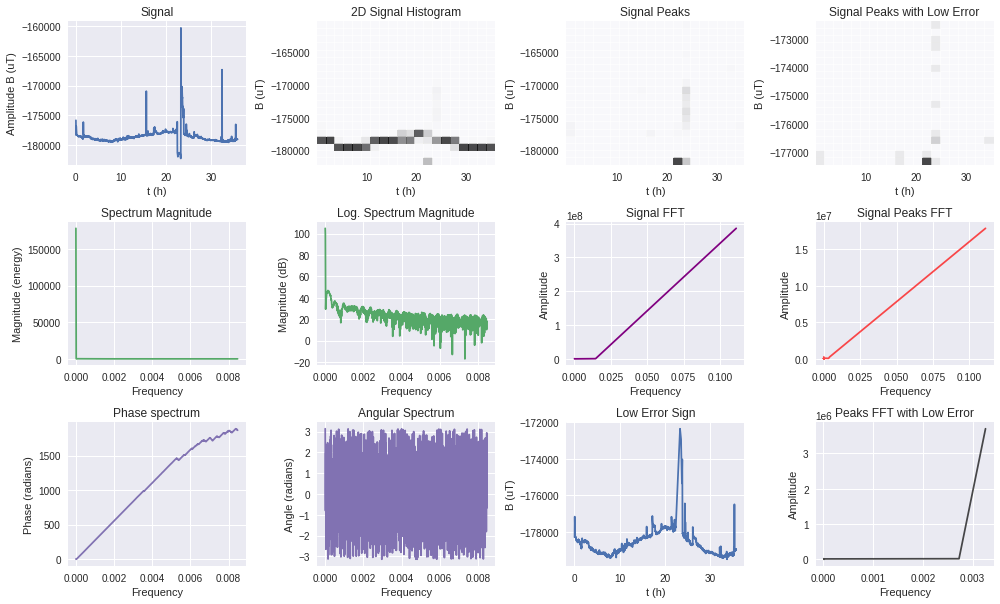

In [7]:
# Data sat:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn')

# insert data file:
file_name = 'flc100-36h.csv'
flag = False

try:
    data = np.genfromtxt('Dados/%s'%file_name, delimiter=',', names=['B', 'var','max','min','t'])
    data = pd.DataFrame(data, columns=['B','var','max','min','t'])[1:]
    flag = True
except:
    try:
        data = np.genfromtxt('Dados/%s'%file_name, delimiter=',', names=['B', 'var','t'])
        data = pd.DataFrame(data, columns=['B','var','t'])[1:]
        flag = True
    except:
        flag = False
finally:
    if flag == False:
        data = np.genfromtxt('Dados/%s'%file_name, delimiter=',', names=['B','t'])
        data = pd.DataFrame(data, columns=['B','t'])[1:]
        
# simple statistics:
stats = data.describe()

# constantes:
try:
    cte_var = (stats['var'][1])
    cte_mean = (stats['B'][1])
    cte_meanstd = (stats['B'][2])
except:
    cte_mean = (stats['B'][1])
    cte_meanstd = (stats['B'][2])

# datas arrays:
arr_B = np.array(data['B'])
arr_t = np.array(data['t'])
if flag == True:
    try:
        arr_var = np.array(data['var']) 
        arr_max = np.array(data['max'])
        arr_min = np.array(data['min'])
    except:
        arr_var = np.array(data['var'])

# peacks function with stdev:
def pico(data, arr_t, cte_mean, cte_var):
    lstb = []
    lstt = []
    for i, b in enumerate(data):
        if (abs(b) > abs(cte_mean)+abs(cte_var)) or (abs(b) < abs(cte_mean)-abs(cte_var)):
            lstb.append(b)
            lstt.append(arr_t[i])
    return np.array(lstb), np.array(lstt)

# Filter camp:
calm = []
disturb = []
if flag == True:
    uncertz = cte_var
arr_data = np.array(data)

if flag == True:
    for b in arr_data:
        if b[1] <= uncertz:
            calm.append(b)
    calm = np.array(calm)
    try:
        calm_f = pd.DataFrame(calm, columns=['B','var','max','min','t'])
    except:
        calm_f = pd.DataFrame(calm, columns=['B','var','t'])
    
    for b in arr_data:
        if b[1] > uncertz:
            disturb.append(b)
    disturb = np.array(disturb)
    try:
        disturb_f = pd.DataFrame(disturb, columns=['B','var','max','min','t'])
    except:
        disturb_f = pd.DataFrame(disturb, columns=['B','var','t'])
    
    # scal error:
    x1 = np.array(calm_f.t)/3600 # hour
    y1 = np.array(calm_f.B)
    cte_meany1 = np.mean(y1)
    yerr1 = np.array(calm_f['var'])
    cte_vary1 = np.mean(yerr1)

    x2 = np.array(disturb_f.t)/3600 # hour
    y2 = np.array(disturb_f.B)
    cte_meany2 = np.mean(y2)
    yerr2 = np.array(disturb_f['var'])
    cte_vary2 = np.mean(yerr2)
else:
    peaks = [b for b in arr_data if abs(b[0]) > (abs(cte_mean) + cte_meanstd)]
    peaksx = np.array([t[1] for t in peaks])
    peaksy = np.array([b[0] for b in peaks])

# Samplim plot:
dt = arr_t[5] - arr_t[4]  # sampling interval
Fs = 1/dt  # sampling frequency
t = arr_t
s = arr_B  # the signal
flagt = False
for i in arr_t:
    if i > 14450:
        flagt = True
        
# Grafs plot:
fig, axs = plt.subplots(3, 4, figsize=(14, 8.5))

# Plot time signal:
axs[0, 0].set_title("Signal")
axs[0, 0].set_ylabel("Amplitude B (uT)")
if flagt == True:
    axs[0, 0].plot(t/3600, s, color='C0')
    axs[0, 0].set_xlabel("t (h)")
else:
    axs[0, 0].plot(t, s, color='C0')
    axs[0, 0].set_xlabel("t (s)")

# Plot different spectrum types:
axs[1, 0].set_title('Spectrum Magnitude'); axs[1, 0].magnitude_spectrum(s, Fs=Fs, color='C1')
axs[1, 1].set_title('Log. Spectrum Magnitude'); axs[1, 1].magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')

axs[2, 0].set_title('Phase spectrum'); axs[2, 0].phase_spectrum(s, Fs=Fs, color='C3')
axs[2, 1].set_title('Angular Spectrum'); axs[2, 1].angle_spectrum(s, Fs=Fs, color='C3')

# Plot others spectrum's analytics:
axs[0, 1].set_title('2D Signal Histogram')
axs[0, 1].set_ylabel('B (uT)')
if flagt == True:
    axs[0, 1].set_xlabel('t (h)')
    axs[0, 1].hist2d(t/3600, s, bins=20, alpha=0.7)
else:
    axs[0, 1].set_xlabel('t (s)')
    axs[0, 1].hist2d(t, s, bins=20, alpha=0.7)

# Signal Peaks:
if flag == True:
    axs[0, 2].set_title('Signal Peaks')
    axs[0, 2].set_ylabel('B (uT)')
    if flagt == True:
        axs[0, 2].set_xlabel('t (h)')
        axs[0, 2].hist2d(pico(s, t, cte_mean, cte_var)[1]/3600, pico(arr_B, arr_t, cte_mean, cte_var)[0],
                     bins=20, alpha=0.7)
    else:
        axs[0, 2].set_xlabel('t (s)')
        axs[0, 2].hist2d(pico(s, t, cte_mean, cte_var)[1], pico(arr_B, arr_t, cte_mean, cte_var)[0],
                     bins=20, alpha=0.7)
else:
    axs[0, 2].set_title('Signal Peaks')
    axs[0, 2].set_ylabel('B (uT)')
    if flagt == True:
        axs[0, 2].set_xlabel('t (h)')
        axs[0, 2].hist2d(peaksx/3600, peaksy, bins=20, alpha=0.7)
    else:
        axs[0, 2].set_xlabel('t (s)')
        axs[0, 2].hist2d(peaksx, peaksy, bins=20, alpha=0.7)

# Signal Peaks:
axs[1, 2].set_title('Signal FFT')
axs[1, 2].set_xlabel('Frequency')
axs[1, 2].set_ylabel('Amplitude')
axs[1, 2].plot(1/t, abs(np.fft.fft(s)), color='purple')

# Low Error Sign:
if flag == True:
    axs[2, 2].set_title('Low Error Sign')
    axs[2, 2].set_ylabel('B (uT)')
    if flagt == True:
        axs[2, 2].set_xlabel('t (h)')
        axs[2, 2].plot(x1, y1)
    else:
        axs[2, 2].set_xlabel('t (s)')
        axs[2, 2].plot(x1*3600, y1)

# Signal Peaks with Low Error:
if flag == True:
    axs[0, 3].set_title('Signal Peaks with Low Error')
    axs[0, 3].set_ylabel('B (uT)')
    if flagt == True:
        axs[0, 3].set_xlabel('t (h)')
        axs[0, 3].hist2d(pico(y1, x1, cte_meany1, cte_vary1)[1], pico(y1, x1, cte_meany1, cte_vary1)[0],
               bins=20, alpha=0.7)
    else:
        axs[0, 3].set_xlabel('t (s)')
        axs[0, 3].hist2d(pico(y1, x1, cte_meany1, cte_vary1)[1]*3600, pico(y1, x1, cte_meany1, cte_vary1)[0],
               bins=20, alpha=0.7)

# description of signals by FFT:
try:
    if flag == True:
        axs[1, 3].set_title('Signal Peaks FFT')
        axs[1, 3].set_xlabel('Frequency')
        axs[1, 3].set_ylabel('Amplitude')
        axs[1, 3].plot(1/pico(s, t, cte_mean, cte_var)[1], 
                       abs(np.fft.fft(pico(s, t, cte_mean, cte_var)[0])), alpha=0.7, color='red')
    else:
        axs[1, 3].set_title('Signal Peaks FFT')
        axs[1, 3].set_xlabel('Frequency')
        axs[1, 3].set_ylabel('Amplitude')
        axs[1, 3].plot(1/peaksx, 
                       abs(np.fft.fft(peaksy)), alpha=0.7, color='red')
except ValueError:
    print('No evidence peaks')
    
try:
    axs[2, 3].set_title('Peaks FFT with Low Error')
    axs[2, 3].set_xlabel('Frequency')
    axs[2, 3].set_ylabel('Amplitude')
    axs[2, 3].plot(1/((pico(y1, x1, cte_meany1, cte_vary1)[1])*3600),
                   abs(np.fft.fft(pico(y1, x1, cte_meany1, cte_vary1)[0])), alpha=0.7, color='black')
except:
    if flag == False:
        print('Data no Error')
    else:
        print('No evidence peaks')

fig.tight_layout()
plt.show()

In [8]:
# data

In [ ]:
# stats